## Introduction

In this analysis, we will simulate candidate responses to an assessment to explore the relationship between abilities, question difficulties, and performance. The planned steps include:

- Modeling candidate abilities using a **Beta distribution** to capture realistic variability within [0,1].  
- Generating question difficulties with a normal distribution and clipping values to ensure meaningful ranges.  
- Applying a **heuristic probability model** to determine the likelihood of a correct response based on ability and question difficulty.  
- Using **binomial sampling** to produce discrete assessment outcomes.  
- Calculating total scores and skill-specific scores to examine trends relative to candidate abilities.  
- Simulating **project performance** influenced by ability with added variability, and categorizing outcomes into **low**, **medium**, and **high** levels.  
- Setting the stage for a comparison with the **2PL IRT model** to evaluate how the heuristic simulation aligns with formal psychometric modeling.



In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
import seaborn as sns

In [32]:
# ------------------------------------------------------------
# 1. Simulation parameters
# ------------------------------------------------------------
N_CANDIDATES = 300          # total candidates
N_QUESTIONS = 20             # total assessment questions
SKILL_AREAS = ['conceptual', 'applied', 'critical_thinking', 'domain_specific']
QUESTION_DIFFICULTY_MEAN = 0.6  # average question difficulty (probability of being answered correctly)

np.random.seed(42)

In [33]:
# ------------------------------------------------------------
# 2. Generate question metadata
# ------------------------------------------------------------
questions = pd.DataFrame({
    'question_id': range(1, N_QUESTIONS + 1),
    'skill_area': np.random.choice(SKILL_AREAS, N_QUESTIONS),
    'difficulty': np.clip(np.random.normal(QUESTION_DIFFICULTY_MEAN, 0.15, N_QUESTIONS), 0.1, 0.9)
})

display(questions.head(10))

,question_id,skill_area,difficulty
0,1,critical_thinking,0.529579
1,2,domain_specific,0.681384
2,3,conceptual,0.530487
3,4,critical_thinking,0.530141
4,5,critical_thinking,0.636294
5,6,domain_specific,0.313008
6,7,conceptual,0.341262
7,8,conceptual,0.515657
8,9,critical_thinking,0.448075
9,10,applied,0.647137


## Why We Use a Beta Distribution

We use a **Beta distribution** to model candidate ability because it naturally stays within the range **[0, 1]**, representing normalized skill levels or probabilities.  
Unlike a normal distribution, it prevents invalid negative or >1 values and allows flexible shapes—symmetric, skewed left, or skewed right—by adjusting its parameters.  
This makes it ideal for simulating realistic populations with varying ability levels while maintaining numerical stability.


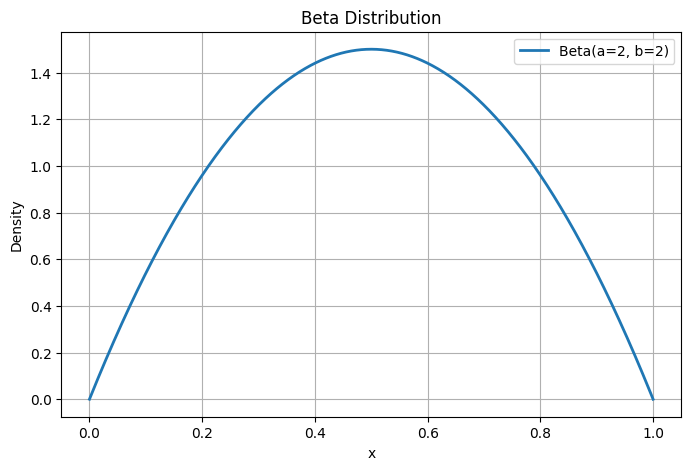

In [34]:
# Parameters for the Beta distribution
a, b = 2, 2

# Generate x values between 0 and 1
x = np.linspace(0, 1, 1000)

# Compute the probability density function (PDF)
y = beta.pdf(x, a, b)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f'Beta(a={a}, b={b})', linewidth=2)
plt.title('Beta Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


## Heuristic Response Probability

The heuristic probability model was designed to capture the intuition that a candidate's chance of answering a question correctly **increases with ability** and **depends on question difficulty**.  

Starting from the goal:

- Let $A$ be the candidate's ability, bounded between $0$ and $1$.
- Let $D$ be the question's difficulty, also between $0$ and $1$.
- We want $P(\text{correct})$ to increase when $A$ is high and when $D$ is high (easier question).

A simple ratio that satisfies these conditions is:

$$
P(\text{correct}) = \frac{A}{A + (1 - A) \cdot \frac{1}{D}}
$$

**Rationale:**

1. When $A \to 1$ (high ability), the numerator dominates and $P(\text{correct}) \to 1$.
2. When $A \to 0$ (low ability), the numerator is small and $P(\text{correct}) \to 0$.
3. When $D$ is higher (easier question, closer to 1), the denominator decreases, increasing $P(\text{correct})$.
4. The formula is bounded in $[0,1]$, making it suitable as a probability.

This is a **heuristic approximation** of a full IRT model: it captures the main behavior of probability increasing with ability relative to difficulty, without requiring logistic functions or additional parameters.


## Simulating Responses with a Binomial Distribution

After computing the probability of a correct answer for each candidate-question pair, we simulate actual responses using a **binomial distribution**:

$$
\text{response} \sim \text{Binomial}(n=1, p=P(\text{correct}))
$$

- $n=1$ because each question is answered **once**.  
- $p = P(\text{correct})$ is the probability computed from the candidate’s ability and question difficulty.  
- The output is **1** for a correct answer and **0** for an incorrect answer.

This approach turns the abstract probabilities into **discrete simulated responses** that mimic real test outcomes.


In [35]:
# ------------------------------------------------------------
# 3. Simulate candidate ability and responses
# ------------------------------------------------------------
# Each candidate has a latent "ability" level between 0 and 1
candidate_ability = np.random.beta(a=2, b=2, size=N_CANDIDATES)

# Probability of correct answer depends on both ability and question difficulty
def simulate_responses(ability, questions_df):
    probs = ability / (ability + (1 - ability) * (1 / questions_df['difficulty'].values))
    responses = np.random.binomial(1, probs)  # 1 = correct, 0 = incorrect
    return responses

response_matrix = np.array([
    simulate_responses(ability, questions) for ability in candidate_ability
])
response_matrix = np.column_stack((response_matrix, candidate_ability))

In [36]:
# ------------------------------------------------------------
# 4. Compute assessment scores
# ------------------------------------------------------------
columns = [f"Q{i+1}" for i in range(response_matrix.shape[1] - 1)] + ["ability"]
assessment_df = pd.DataFrame(response_matrix, columns=columns)
assessment_df['candidate_id'] = range(1, N_CANDIDATES + 1)
assessment_df['total_score'] = assessment_df[[f"Q{i}" for i in range(1, N_QUESTIONS + 1)]].sum(axis=1)
assessment_df['avg_score'] = assessment_df['total_score'] / N_QUESTIONS

# Skill-specific average scores
for skill in SKILL_AREAS:
    question_ids = questions[questions['skill_area'] == skill]['question_id']
    assessment_df[f"{skill}_score"] = assessment_df[[f"Q{i}" for i in question_ids]].mean(axis=1)

display(assessment_df.head(3))


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q19,Q20,ability,candidate_id,total_score,avg_score,conceptual_score,applied_score,critical_thinking_score,domain_specific_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.432748,1,5.0,0.25,0.25,0.0,0.444444,0.000000
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.720396,2,12.0,0.60,0.75,0.0,0.555556,0.666667
2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.847320,3,13.0,0.65,0.75,1.0,0.444444,0.833333


In [37]:
# ------------------------------------------------------------
# 5. Determine who passes the assessment
# ------------------------------------------------------------
PASS_THRESHOLD = np.percentile(assessment_df['total_score'], 70)  # top 30% pass
passed_candidates = assessment_df[assessment_df['total_score'] >= PASS_THRESHOLD].copy()
passed_candidates['passed'] = True

## Observing Trends

The **total score vs ability** graph shows a clear positive trend: candidates with higher abilities tend to achieve higher overall scores. This is because the total score aggregates responses across all questions, **averaging out random variability** from individual question outcomes.

In contrast, plotting **scores per question type (skill area)** can hide this trend. This happens because:

- Each skill score is averaged over a smaller number of questions, making it more sensitive to **random success or failure** on individual items.
- Limited variability in question difficulty can flatten differences between candidates (clipping question difficulties to [0.1, 0.9])
- Random sampling from the binomial response model adds noise, which has a stronger effect on small question subsets.

**Conclusion:** Aggregating over all questions reveals the underlying ability-score relationship more clearly, while small skill-level averages can obscure it due to stochastic variation and limited sample size.


Linear regression equation: total_score = 18.07 * ability + -1.63


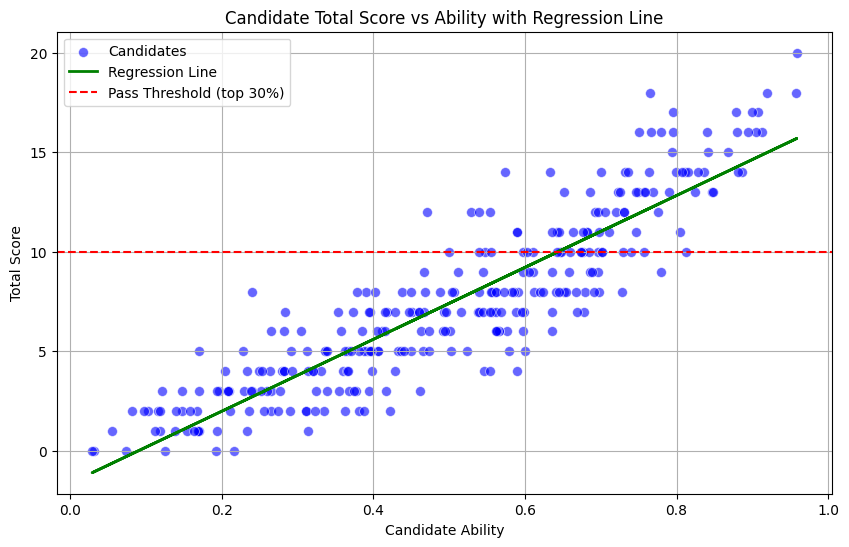

In [38]:
# Scatter plot: candidate ability vs total score
plt.figure(figsize=(10, 6))
sns.scatterplot(x=candidate_ability, y=assessment_df['total_score'], s=50, color='blue', alpha=0.6, label='Candidates')

# Fit linear regression line
slope, intercept = np.polyfit(candidate_ability, assessment_df['total_score'], 1)
print(f"Linear regression equation: total_score = {slope:.2f} * ability + {intercept:.2f}")

# Plot regression line
plt.plot(candidate_ability, slope * candidate_ability + intercept, color='green', linewidth=2, label='Regression Line')

# Draw the pass threshold
plt.axhline(y=PASS_THRESHOLD, color='red', linestyle='--', label=f'Pass Threshold (top 30%)')

plt.title('Candidate Total Score vs Ability with Regression Line')
plt.xlabel('Candidate Ability')
plt.ylabel('Total Score')
plt.legend()
plt.grid(True)
plt.show()

### Why the Ability vs Score Trend May Not Be Clear

Even though higher ability should lead to higher scores, the plot may not show a clear trend due to:

1. **Heuristic response model flattening probabilities**: For mid-range abilities and typical question difficulties, probabilities of success are similar, reducing visible differences.
2. **Small number of questions per skill**: Averages over few questions introduce variability; chance alone can make high-ability candidates score lower on some skills.
3. **Limited difficulty spread**:  Clipping question difficulties to [0.1, 0.9] reduces variation in scores.
4. **Random sampling noise**: Each response is sampled from a binomial distribution, adding stochasticity.
5. **Skill-level aggregation**: Averaging over questions per skill smooths differences, masking the correlation.

**Ways to clarify the trend:**
- Increase the number of questions per skill.
- Increase the spread of abilities (e.g., using a more extreme Beta distribution).
- Use stronger dependency in the heuristic formula.

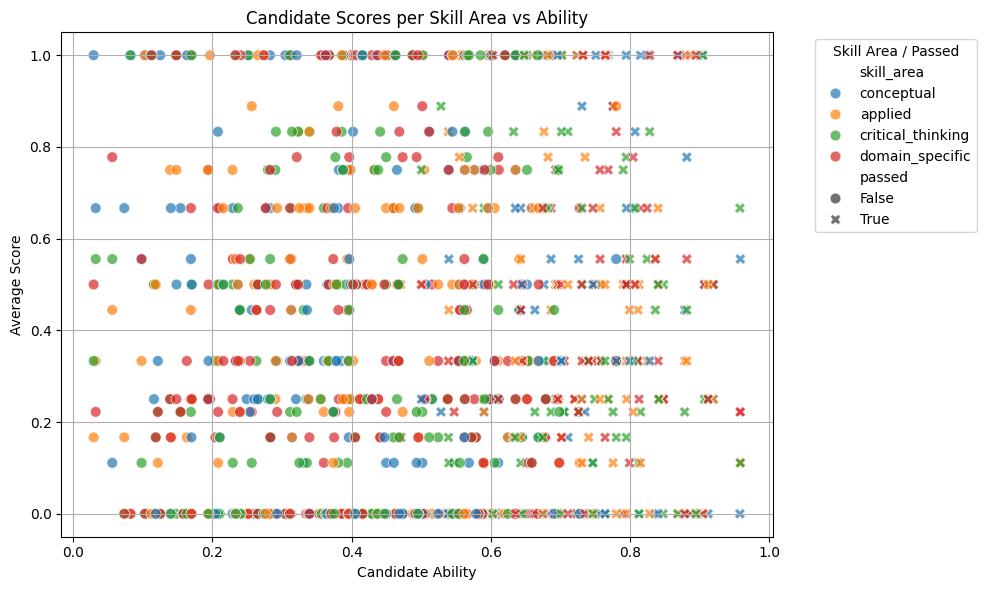

In [39]:
# Prepare a "long-form" DataFrame for easier plotting
plot_df = pd.DataFrame({
    'ability': np.repeat(candidate_ability, len(SKILL_AREAS)),
    'skill_area': np.tile(SKILL_AREAS, N_CANDIDATES),
    'score': np.concatenate([assessment_df[f"{skill}_score"].values for skill in SKILL_AREAS])
})

# Add pass/fail info
plot_df['passed'] = np.repeat((assessment_df['total_score'] >= PASS_THRESHOLD).values, len(SKILL_AREAS))

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='ability',
    y='score',
    hue='skill_area',          # color by skill
    style='passed',            # shape by pass/fail
    palette='tab10',
    alpha=0.7,
    s=60
)

plt.title('Candidate Scores per Skill Area vs Ability')
plt.xlabel('Candidate Ability')
plt.ylabel('Average Score')
plt.grid(True)
plt.legend(title='Skill Area / Passed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Simulating Project Performance

Project performance was simulated as a function of candidate ability with added random variability (Random Gaussian noise with $\sigma = 0.1$) to reflect real-world differences in outcomes.  

The resulting performance values were then categorized into three levels — **low**, **medium**, and **high** — providing an intuitive measure of project quality for analysis and visualization.

In [40]:
# ------------------------------------------------------------
# 6. Simulate project performance for those who passed
# ------------------------------------------------------------
# Performance influenced by ability, with added noise
performance_prob = candidate_ability[passed_candidates['candidate_id'] - 1] + np.random.normal(0, 0.1, len(passed_candidates))
performance_prob = np.clip(performance_prob, 0, 1)

# Categorize project quality
performance_levels = pd.cut(
    performance_prob,
    bins=[0, 0.33, 0.66, 1.0],
    labels=['low', 'medium', 'high']
)

passed_candidates['project_quality'] = performance_levels

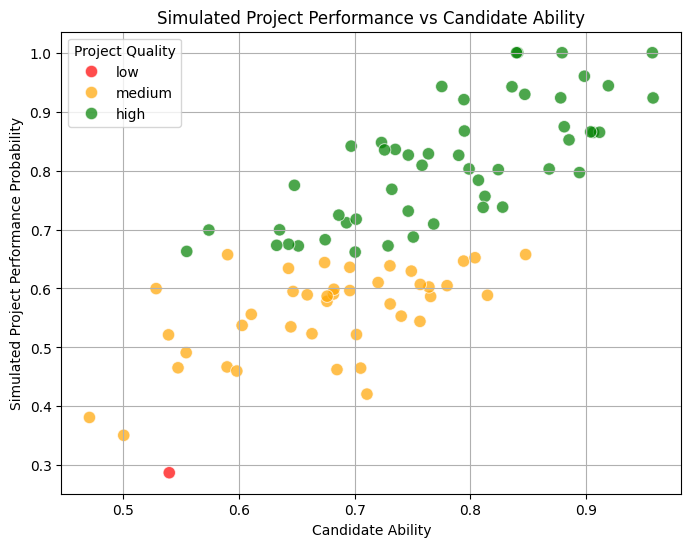

In [41]:
# Scatter plot: performance_prob vs candidate ability
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=candidate_ability[passed_candidates['candidate_id'] - 1],
    y=performance_prob,
    hue=passed_candidates['project_quality'],
    palette={'low':'red', 'medium':'orange', 'high':'green'},
    s=80,
    alpha=0.7
)

plt.title('Simulated Project Performance vs Candidate Ability')
plt.xlabel('Candidate Ability')
plt.ylabel('Simulated Project Performance Probability')
plt.grid(True)
plt.legend(title='Project Quality')
plt.show()

In [42]:
# ------------------------------------------------------------
# 7. Export simulated data
# ------------------------------------------------------------
assessment_df.to_csv("data/assessment_results.csv", index=False)
questions.to_csv("data/questions_metadata.csv", index=False)
passed_candidates.to_csv("data/passed_candidates_with_performance.csv", index=False)

print("Simulation complete.")
print(f"Generated {len(assessment_df)} candidates, of which {len(passed_candidates)} passed.")
print("Files saved in ./data/")

Simulation complete.
Generated 300 candidates, of which 93 passed.
Files saved in ./data/


## Conclusion

In this analysis, we explored how candidate abilities and question difficulties can be simulated and quantified to study assessment outcomes. We discussed the use of **Beta distributions** for modeling bounded abilities, **heuristic probability models** for simulating responses, and **binomial sampling** to generate realistic discrete results.  

We also examined how **aggregating scores** across all questions highlights the relationship between ability and performance, while skill-specific averages may obscure trends due to variability and small sample sizes. Finally, we simulated **project performance** based on candidate ability, incorporating randomness and categorizing outcomes into intuitive quality levels.  

Overall, these concepts demonstrate how **heuristic probabilistic modeling** can can be used to simulate real-world data for assessing candidate scores and performance. In a further step, we will be comparing these insights with the **2PL IRT model** to evaluate how well our heuristic simulation aligns with a formal psychometric approach.
